# Sky Saber + Velour Demo
Resources:
- [Images and annotations](https://demo01.chariot.striveworks.us/projects/2KVFMuUcjVJUHXGUNXnRVmaRxNq/datasets/2U7QIpKkOLhI0SDDaXptxWCiIjW?version=2VRqi9vpGSDUEOVPKbQy7B8uoNl)
- [Ship model](https://demo01.chariot.striveworks.us/projects/2FisBl1MgB7slir8zvf3uJ8BZOk/models/2V4z0nROtQOGO11vkfLdqEdwYLP)
- [Helicopter and plane model](https://demo01.chariot.striveworks.us/projects/2FisBl1MgB7slir8zvf3uJ8BZOk/models/2VfiKsH1GFKuifT1zxGnfowvwGC)


Before you run this notebook, be sure you have the following in `sample_notebooks/skysaber/`:
```python
- annotations.jsonl # the Sky Saber annotations provided in the first link above
- metadata.dat # the metadata pickle that Eddy provided via slack
- images/*.jpeg # a directory of Sky Saber satellite images provided in the first link above
```

## Setup

In [1]:
from io import BytesIO
import json
import os
import pickle
import PIL.Image
import requests
from tqdm import tqdm
import collections

from velour.client import Dataset as VelourDataset, Model as VelourModel, Client, ClientException
from velour.viz import create_combined_segmentation_mask
from velour.metatypes import ImageMetadata
from velour import (
    enums, Annotation,
    GroundTruth,
    Label,
)
from velour.schemas import BoundingBox, BasicPolygon, Point
from chariot.client import connect
from chariot.datasets import Dataset as ChariotDataset
from chariot.models import Model as ChariotModel

from integration_utils.chariot import get_chariot_model_integration

def _draw_bounding_boxes(image: PIL.Image, annotation: dict):
    """Helper function to draw bounding boxes on a Sky Saber image"""
    label = annotation['class_label']
    bb = ([annotation['bbox'][x] for x in ['xmin', 'ymin', 'xmax', 'ymax']])
    
    draw = PIL.ImageDraw.Draw(image)
    draw.rectangle((bb), outline="red")
    draw.text((bb[0], bb[1]), label)

    return image


def _load_image_from_annotation(annotation:dict) -> PIL.Image:
    """Return a PIL.Image for a given annotation"""
    image_path = f"./skysaber/images/{os.path.basename(annotation['path'])}"
    return PIL.Image.open(image_path)


def _load_image_from_image_metdata(img_metadata:ImageMetadata) -> PIL.Image:
    """Return a PIL.Image given an ImageMetadata object"""
    image_path = f"./skysaber/images/{img_metadata.uid}"
    return PIL.Image.open(image_path)



def _generate_groundtruth(annotation_obj: dict, approved_metadata:list, metadata: dict) -> GroundTruth:
    """Creates a Groundtruth using a Sky Saber annotation dictionary"""
    metadata_entry = metadata[annotation_obj['metadata_key']]
    height, width = _load_image_from_annotation(annotation_obj).size


    img_metadata = ImageMetadata(
        uid = annotation_obj['image_name'],
        height=height,
        width=width,
        metadata = {key:str(metadata_entry[key]) for key in approved_metadata}
    ).to_datum()

    img_annotations = []
    for annotation in annotation_obj['annotations']:
        label = annotation['class_label']

        img_annotations.append(Annotation(
                        task_type=enums.TaskType.DETECTION,
                        labels=[Label(key="class_label", value=label)],
                        metadata=[],
                        bounding_box=BoundingBox(
                            polygon=BasicPolygon(
                                points=[
                                    Point(x=annotation['bbox']['xmin'], y=annotation['bbox']['ymin']),
                                    Point(x=annotation['bbox']['xmax'], y=annotation['bbox']['ymin']),
                                    Point(x=annotation['bbox']['xmax'], y=annotation['bbox']['ymax']),
                                    Point(x=annotation['bbox']['xmin'], y=annotation['bbox']['ymax']),
                                ]
                            )
                        ),
                    )
        )

    gt = GroundTruth(
        datum=img_metadata,
        annotations=img_annotations
    )
    return gt

In [2]:
metadata_path = "./skysaber/metadata.dat"   
annotation_path = "./skysaber/annotations.jsonl"
dataset_name = "skysaber-demo"
approved_metadata = ['source', 'cloudCover', 'ageDays', 'acquisitionDate', 'colorBandOrder', 'offNadirAngle', 'groundSampleDistance', 'geometry']

client = Client("http://localhost:8000")
connect("https://demo01.chariot.striveworks.us/")

N_IMAGES = 10

Succesfully connected to http://localhost:8000/.


Chariot version 0.4.18 is newer than sdk version 0.4.17


# Ingest data

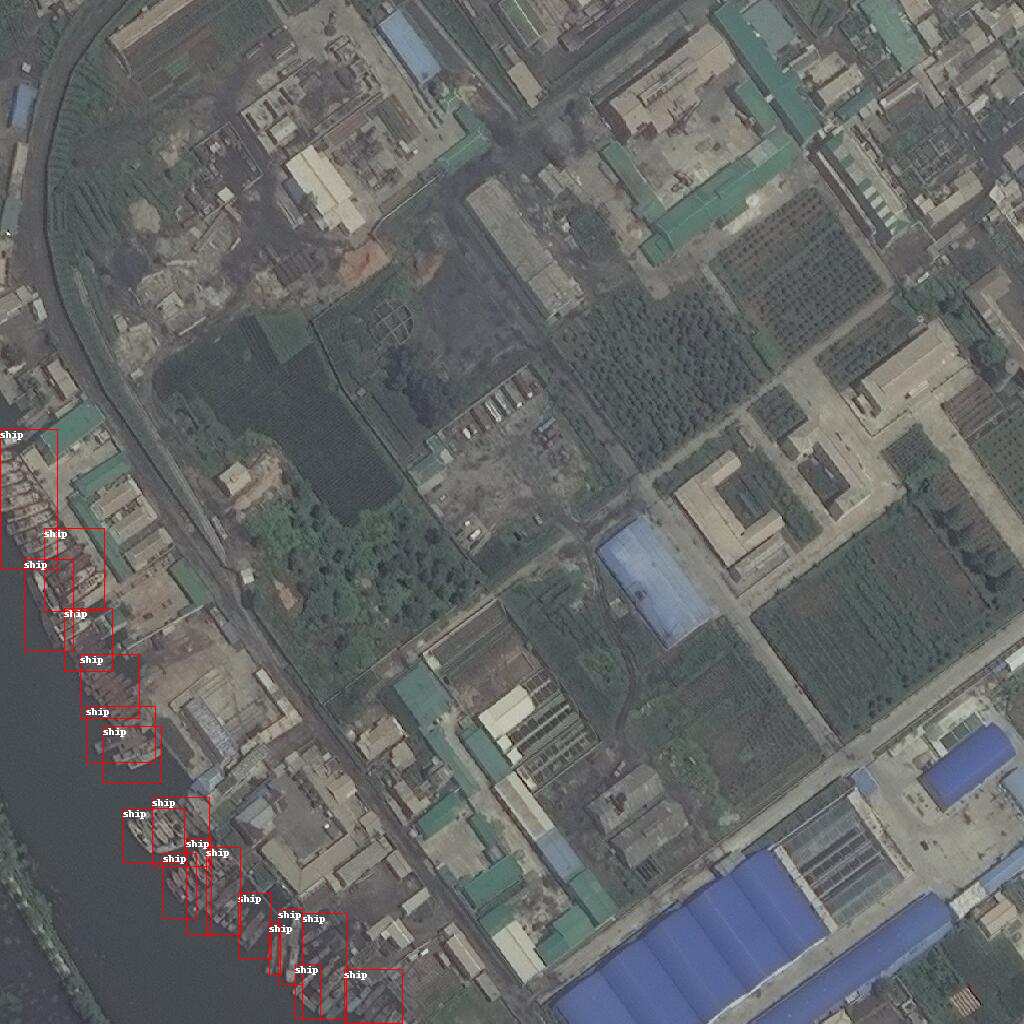

In [3]:
# setup metadata

with open(metadata_path, "rb") as f:
    raw_metadata = pickle.load(f)

metadata = {entry['id']:entry for entry in raw_metadata}


# setup annotations
with open(annotation_path, 'r') as json_file:
    json_list = list(json_file)

annotations = []
i = 0

while len(annotations) < N_IMAGES:
    annotation = json.loads(json_list[i])
    annotation['metadata_key'] = os.path.basename(annotation['path']).split('_')[0]
    annotation['image_name'] = os.path.basename(annotation['path'])

    # only include an image if we have metadata for it
    if annotation['metadata_key'] in metadata.keys():
        annotations.append(annotation)

    i += 1
    

# show example(s)
for annotation_obj in annotations[:1]:
    image = _load_image_from_annotation(annotation_obj)
    for annotation in annotation_obj['annotations']:
        drawn_image = _draw_bounding_boxes(image=image, annotation=annotation)

    display(drawn_image)

## Add GroundTruths to Velour

In [8]:

try:
    client.delete_dataset(dataset_name, timeout=5)
except:
    pass

dataset = VelourDataset.create(client, dataset_name)


annotation_obj = annotations[0]

metadata_entry = metadata[annotation_obj['metadata_key']]
height, width = _load_image_from_annotation(annotation_obj).size


img_metadata = ImageMetadata(
    uid = annotation_obj['image_name'],
    height=height,
    width=width,
    metadata = {key:str(metadata_entry[key]) for key in approved_metadata},
    geospatial =metadata[annotation_obj['metadata_key']]['geometry']
).to_datum()

img_annotations = []
for annotation in annotation_obj['annotations']:
    label = annotation['class_label']

    img_annotations.append(Annotation(
                    task_type=enums.TaskType.DETECTION,
                    labels=[Label(key="class_label", value=label)],
                    metadata=[],
                    bounding_box=BoundingBox(
                        polygon=BasicPolygon(
                            points=[
                                Point(x=annotation['bbox']['xmin'], y=annotation['bbox']['ymin']),
                                Point(x=annotation['bbox']['xmax'], y=annotation['bbox']['ymin']),
                                Point(x=annotation['bbox']['xmax'], y=annotation['bbox']['ymax']),
                                Point(x=annotation['bbox']['xmin'], y=annotation['bbox']['ymax']),
                            ]
                        )
                    ),
                )
    )

gt = GroundTruth(
    datum=img_metadata,
    annotations=img_annotations
)

dataset.add_groundtruth(gt)

dataset.finalize()


{'type': 'Polygon', 'coordinates': [[[125.2750725, 38.760525], [125.3902365, 38.775069], [125.5054005, 38.789613], [125.5051935, 38.71402425], [125.5049865, 38.6384355], [125.3902005, 38.6244225], [125.2754145, 38.6104095], [125.2752435, 38.68546725], [125.2750725, 38.760525]]]}


<Response [200]>

In [9]:
# TODO geometry metadata is stored as a string, which probably isn't correct

try:
    client.delete_dataset(dataset_name, timeout=5)
except:
    pass

dataset = VelourDataset.create(client, dataset_name)

for annotation_obj in annotations:
    gt = _generate_groundtruth(annotation_obj, approved_metadata=approved_metadata, metadata=metadata)
    annotation_obj['img_datum'] = gt.datum
    dataset.add_groundtruth(gt)

dataset.finalize()


<Response [200]>

## Generate inferences and evaluation metrics

In [11]:
model_configs = [
    {"name": "ships-broad", "project_name": "Global", "label": 'class_label'},
    {"name": "ships-updated", "project_name": "Global", "label": 'class_label'},
    {"name": "ship-detector", "project_name": "Abe", "label": 'class_label'},
    {"name": "ship-detector-version-2", "project_name": "Abe", "label": 'class_label'},
    {"name": "ships-final-version", "project_name": "Abe", "label": 'class_label'},
    {"name": "small-ship-detector", "project_name": "Abe", "label": 'class_label'},
]

metric_configs = [
    {}, {"max_area":30*300}
]

model_objects = []

for model_config in model_configs:
    try:
        chariot_model = ChariotModel(
            name=model_config["name"], project_name=model_config["project_name"]
        )

        (
            velour_chariot_model,
            velour_chariot_parser,
        ) = get_chariot_model_integration(client, chariot_model, "detect")

        for annotation_obj in annotations:
            image_metadata = annotation_obj["img_datum"]
            image = _load_image_from_image_metdata(image_metadata)

            result = chariot_model.detect(image)
            prediction = velour_chariot_parser(datum=image_metadata, result=result)

            velour_chariot_model.add_prediction(prediction)

        velour_chariot_model.finalize_inferences(dataset)
        model_objects.append(velour_chariot_model)

        for config in metric_configs:
            velour_chariot_model.evaluate_detection(
                dataset=dataset,
                label_key=model_config['label'],
                **config
            )
    except Exception as e:
        print(f'Failed to generate inferences with {model_config} with exception: {e}')

Failed to generate inferences with {'name': 'ships-broad', 'project_name': 'Global', 'label': 'class_label'} with exception: 'NoneType' object is not subscriptable
Failed to generate inferences with {'name': 'ships-updated', 'project_name': 'Global', 'label': 'class_label'} with exception: Model 'ships-updated' does not exist or you do not have access.
Failed to generate inferences with {'name': 'ship-detector', 'project_name': 'Abe', 'label': 'class_label'} with exception: 'NoneType' object is not subscriptable
Failed to generate inferences with {'name': 'ship-detector-version-2', 'project_name': 'Abe', 'label': 'class_label'} with exception: 'NoneType' object is not subscriptable
Failed to generate inferences with {'name': 'ships-final-version', 'project_name': 'Abe', 'label': 'class_label'} with exception: 'NoneType' object is not subscriptable
Failed to generate inferences with {'name': 'small-ship-detector', 'project_name': 'Abe', 'label': 'class_label'} with exception: 'NoneType'

## Find the best model

In [ ]:
evaluations = client.get_bulk_evaluations(datasets=dataset_name)
ranked_evaluations = client.get_ranked_evaluations(dataset_name=dataset_name, metric='mAP', parameters={"iou": .6})
ranked_evaluations

ClientException: Didn't find any evaluations to rank on using {'metric': 'mAP', 'label_keys': [], 'parameters': {'iou': 0.6}}

In [ ]:
for annotation_obj in annotations:
    """Creates a Groundtruth using a Sky Saber annotation dictionary"""
    metadata_entry = metadata[annotation_obj['metadata_key']]
    print([Metadatum(key=key, value=str(metadata_entry[key])) for key in approved_metadata])

In [ ]:
from sqlalchemy.sql import func

cast(models.Task.geometry, Geography(srid=SRID))

# ref: https://postgis.net/docs/ST_GeogFromWKB.html
record1_geography_2 = session.query(func.ST_GeogFromWKB(MyTable.geometry)
                                   ).filter(MyTable.id == 1).one()

In [ ]:
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String, Sequence
from geoalchemy2 import Geometry

Base = declarative_base()

class User(Base):
    __tablename__ = 'users'
    id = Column(Integer, Sequence('user_id_seq'), primary_key=True)
    name = Column(String(50))
    fullname = Column(String(50))
    password = Column(String(12))
    geom = Column(Geometry('POINT'))
GeoAlchemy2 also provides functionality for spatial queries. From the docs:

query = session.query(Lake).filter(Lake.geom.ST_Contains('POINT(4 1)'))

In [ ]:
for annotation_obj in annotations:
    for point in metadata[annotation_obj['metadata_key']]['geometry']['coordinates'][0]:
        print(point)
    print('----')
    # [value['geometry']['coordinates'] for key, value in metadata.items()]

[[125.2750725, 38.760525], [125.3902365, 38.775069], [125.5054005, 38.789613], [125.5051935, 38.71402425], [125.5049865, 38.6384355], [125.3902005, 38.6244225], [125.2754145, 38.6104095], [125.2752435, 38.68546725], [125.2750725, 38.760525]]


ClientException: cannot edit dataset `skysaber-demo` since it has been finalized.